# ECE/CS 434 | MP2: DUET
<br />
<nav>
    <span class="alert alert-block alert-warning">Due on Monday Feb 27 11:59PM on Gradescope</span>
   
</nav><br> 


## Objective
In this MP, you will:
- Implement DUET algorithm to separate a mixture of N voice signals from received from two microphones

---
## Problem Overview
Consider a problem of separating N sources ($S_1$, $S_2$, ... $S_N$) from recordings on 2 microphones ($R_1$ and $R_2$).
According to DUET algorithm, you will need to perform the following steps:

- Calculate the short-time Fourier transform of two received signals to get the time-frequency spectrograms
- Calculate the ratio of the two time-frequency spectrograms to get relative delay and attenuation
- Cluster the time-frequency bins in the 2D space spanned by relative delay and attenuation
- Recover the original N signals based on the clustering results

You can refer to the original DUET paper in ICASSP 2000: "Blind separation of disjoint orthogonal signals: demixing N sources from 2 mixtures" and this tutorial in Blind speech separation, 2007 - Springer: "The DUET blind source separation algorithm"

For the sake of easier clustering, the exact number of sources N will be provided to you.

You can assume there is no time-frequency bin collision for any two sources.

---
## Imports & Setup
To run the grading script of this MP, you will need to install the Python [SpeechRecognition](https://pypi.org/project/SpeechRecognition/) package. The SpeechRecognition package also requires the dependency [pocketsphinx](https://pypi.org/project/pocketsphinx/). You may directly use pip install to install both packages.
The following `code` cell, when run, imports the libraries you might need for this MP. Feel free to delete or import other commonly used libraries. Double check with the TA if you are unsure if a library is supported.

In [2]:
import numpy as np
import scipy.io.wavfile 
import speech_recognition as sr
from scipy import signal
# from sklearn.cluster import KMeans
import scipy as scipy
# from sklearn.mixture import GaussianMixture


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    plt.style.use("seaborn") # This sets the matplotlib color scheme to something more soothing
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')

# This function is used to format test results. You don't need to touch it.
def display_table(data):
    from IPython.display import HTML, display
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

C:\Users\chazp\AppData\Local\Temp\ipykernel_52156\1804353281.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn") # This sets the matplotlib color scheme to something more soothing


### Sanity-check

Running the following code block verifies that the correct module versions are indeed being used. 

Try restarting the Python kernel (or Jupyter) if there is a mismatch even after intalling the correct version. This might happen because Python's `import` statement does not reload already-loaded modules even if they are updated.

In [3]:
if __name__ == '__main__':
    from IPython.display import display, HTML

    def printc(text, color):
        display(HTML("<text style='color:{};weight:700;'>{}</text>".format(color, text)))

    _requirements = [r.split("==") for r in open(
        "packages.txt", "r").read().split("\n")]

    import sys
    for (module, expected_version) in _requirements:
        try:
            if sys.modules[module].__version__ != expected_version:
                printc("[✕] {} version should to be {}, but {} is installed.".format(
                    module, expected_version, sys.modules[module].__version__), "#f44336")
            else:
                printc("[✓] {} version {} is correct.".format(
                    module, expected_version), "#4caf50")
        except:
            printc("[–] {} is not imported, skipping version check.".format(
                module), "#03a9f4")

---
## Your Implementation
Implement your localization algorithm in the function `duet_source_separation(mic_data_folder, NUM_SOURCES)`. Do **NOT** change its function signature. You are, however, free to define and use helper functions. 

Your implementation for `duet_source_separation` function should **NOT** output any plots or data. It should only return the separated sources.

Your next attempt should be windowing the voiced regions in the time domain before taking the stft

[[3.14159308]
 [3.14101881]
 [3.1421627 ]]


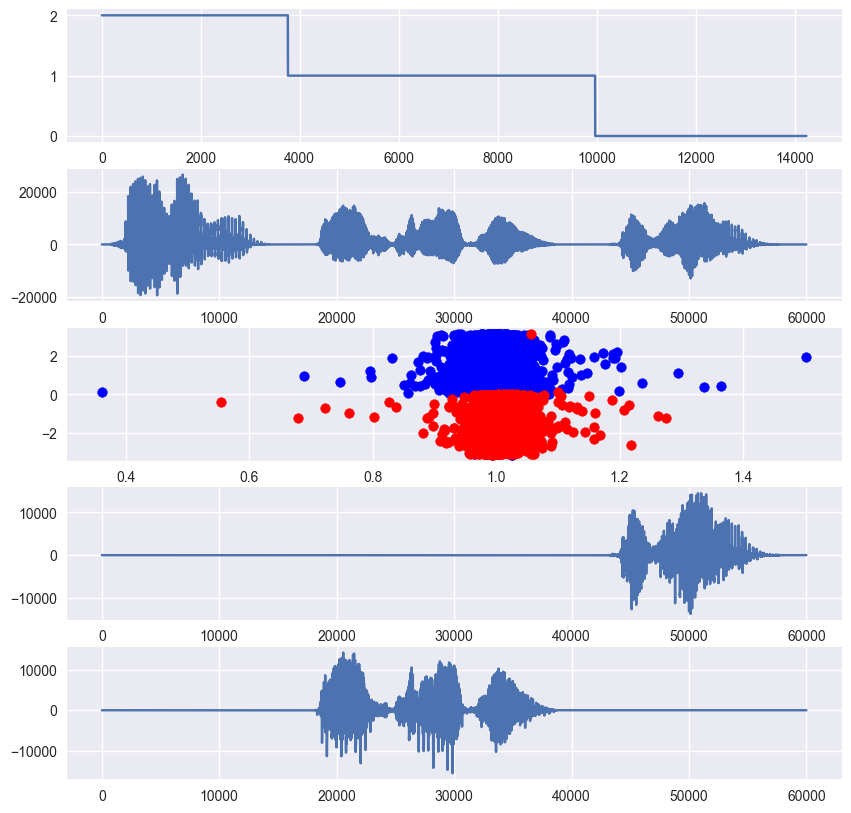

In [8]:


NUM_SOURCES = 3
mic_data_folder = './dataset3'


# if(NUM_SOURCES == 1):
    # return np.array(x1)

fs1, x1 = scipy.io.wavfile.read(mic_data_folder + '/0.wav')
fs2, x2 = scipy.io.wavfile.read(mic_data_folder+ '/1.wav')

nper = 512
nover = 100
toReturn = np.zeros((NUM_SOURCES,len(x1)))

freqs1, times1, spec1 = signal.stft(x1,fs1, nperseg=nper, noverlap= nover) #nperseg default 256 noverlap 
freqs2, times2, spec2 = signal.stft(x2,fs2, nperseg= nper, noverlap= nover)
angs = []
mags = []
indices = [] # (frequency,time)

for  j in range(0,times1.shape[0]): 
    for i in range(1,freqs1.shape[0]//2):
        if np.abs(spec1[i][j]) >  .1 and np.abs(spec2[i][j]) > .1:
            temp = spec2[i][j]/spec1[i][j]
            mags.append(np.abs(temp))
            # angs.append(np.angle(temp))
            angs.append(((np.arctan2(temp.imag, temp.real)/(freqs1[i])) + np.pi) %(2*np.pi))
            indices.append((i,j))


angs = np.array(angs).reshape(-1,1)
# mags = np.array(mags).reshape(-1,1)

# toClass = np.column_stack((angs,mags))
toClass = angs

codebook, useless  = scipy.cluster.vq.kmeans(obs = toClass, k_or_guess= NUM_SOURCES)
classed = np.zeros(len(indices))

print(codebook)

for i in range(len(classed)):
    diffs = codebook - angs[i]
    classed[i] = np.argmin(np.abs(diffs))
# classifier = GaussianMixture(n_components=NUM_SOURCES)
# classed = classifier.fit_predict(X = toClass)

for i in range(len(classed-10) //10): # smoothing the classifications
    classed[i*10:i*10 + 10] = np.round(np.mean(classed[i*10:i*10 + 10]))


indices = np.array(indices)

#good stuff i think from here on
sourceindeces = []
for i in range(NUM_SOURCES):
    sourceindeces.append(indices[classed == i])



toinverse = []
for source in sourceindeces:
    temp = np.zeros_like(spec1)
    for idx in source:
        temp[idx[0]][idx[1]] = spec1[idx[0], idx[1]]
    toinverse.append(temp)

for i in range(NUM_SOURCES):
    toReturn[i,:] = scipy.signal.istft(toinverse[i], fs1, nperseg=nper, noverlap=nover)[1][:len(x1)]

plt.figure(figsize=(10,10))
plt.subplot(5,1,1)
plt.plot(np.arange(classed.shape[0]),classed)

plt.subplot(5,1,2)
plt.plot(np.arange(x1.shape[0]),x1)


plt.subplot(5,1,3)
toPlot = []
for source in sourceindeces:
    temp = [[],[]]
    for idx in source:
        toUse= spec1[idx[0]][idx[1]]/spec2[idx[0]][idx[1]]
        temp[0].append(np.abs(toUse))
        temp[1].append(np.angle(toUse))
    toPlot.append(temp)

count = 0
cols = {0 :'green', 1 : 'blue', 2 : 'red'}
for c in toPlot:
    plt.scatter(c[0],c[1], color = cols[count])
    count +=1
    # plt.scatter(np.arange(len(toPlot[1])),toPlot[1])

plt.subplot(5,1,4)
# plt.pcolormesh(times1, freqs1, np.abs(spec1), vmin=0,vmax=10)
plt.plot(np.arange(toReturn.shape[1]), toReturn[0,:])

plt.subplot(5,1,5)
plt.plot(np.arange(toReturn.shape[1]), toReturn[1,:])
# plt.pcolormesh(times1, freqs1, np.abs(spec2), vmin=0,vmax=20)

for i in range(NUM_SOURCES):
    scipy.io.wavfile.write('bad'+str(i)+'.wav',fs1,2**15* toReturn[i,:].astype('int'))
# scipy.io.wavfile.write('bad2.wav',fs1,2**15* toReturn[0,:].astype('int'))

In [486]:

def duet_source_separation(mic_data_folder, NUM_SOURCES):
    """DUET source separation algorithm. Write your code here.

    Args:
        mic_data_folder: name of folder (without a trailing slash) containing 
                         two mic datafiles `0.wav` and `1.wav`.

    Returns:
        NUM_SOURCES * recording_length numpy array, where NUM_SOURCES is the number of sources,
        and recording_length is the original length of the recording (in number of samples)

    """
    fs1, x1 = scipy.io.wavfile.read(mic_data_folder + '/0.wav')
    fs2, x2 = scipy.io.wavfile.read(mic_data_folder+ '/1.wav')

    nper = 512
    nover = 100
    toReturn = np.zeros((NUM_SOURCES,len(x1)))

    freqs1, times1, spec1 = signal.stft(x1,fs1, nperseg=nper, noverlap= nover) #nperseg default 256 noverlap 
    freqs2, times2, spec2 = signal.stft(x2,fs2, nperseg= nper, noverlap= nover)
    angs = []
    mags = []
    indices = [] # (frequency,time)

    for  j in range(0,times1.shape[0]): 
        for i in range(1,freqs1.shape[0]//2):
            if np.abs(spec1[i][j]) >  .1 and np.abs(spec2[i][j]) > .1:
                temp = spec2[i][j]/spec1[i][j]
                mags.append(np.abs(temp))
                # angs.append(np.angle(temp))
                angs.append(np.arctan2(temp.imag, temp.real)/(freqs1[i]))
                indices.append((i,j))


    angs = np.array(angs).reshape(-1,1)
    # mags = np.array(mags).reshape(-1,1)

    # toClass = np.column_stack((angs,mags))
    toClass = angs

    codebook, useless  = vq.kmeans(obs = toClass, k_or_guess= NUM_SOURCES)
    classed = np.zeros(len(indices))

    for i in range(len(classed)):
        diffs = codebook - angs[i]
        classed[i] = np.argmin(np.abs(diffs))
    # classifier = KMeans(n_clusters= NUM_SOURCES)
    # classed = classifier.fit_predict(X = toClass)
    # classifier = GaussianMixture(n_components=NUM_SOURCES)
    # classed = classifier.fit_predict(X = toClass)

    for i in range(len(classed-10) //10): # smoothing the classifications
        classed[i*10:i*10 + 10] = np.round(np.mean(classed[i*10:i*10 + 10]))


    indices = np.array(indices)

    #good stuff i think from here on
    sourceindeces = []
    for i in range(NUM_SOURCES):
        sourceindeces.append(indices[classed == i])



    toinverse = []
    for source in sourceindeces:
        temp = np.zeros_like(spec1)
        for idx in source:
            temp[idx[0]][idx[1]] = spec1[idx[0], idx[1]]
        toinverse.append(temp)

    for i in range(NUM_SOURCES):
        toReturn[i,:] = scipy.signal.istft(toinverse[i], fs1, nperseg=nper, noverlap=nover)[1][:len(x1)]

    return 2**15 * toReturn.astype('int16')

---
## Running and Testing
Use the cell below to run and test your code, and to get an estimate of your grade.

In [487]:
def calculate_score(calculated, expected):
    student_result = set()
    calculated = np.array(calculated)
    if calculated.shape[0] != len(expected):
      return 0, {'Incorrect number of sources!'}
    for i in range(calculated.shape[0]):
        scipy.io.wavfile.write("temp.wav",22050,calculated[i,:])
        r = sr.Recognizer()
        with sr.AudioFile("temp.wav") as source:
            audio = r.record(source)
        try:
            text = r.recognize_sphinx(audio)
            student_result.add(text.lower())
        except:
            student_result.add("Sphinx could not understand audio")
    score = len(student_result.intersection(expected))/len(expected)
    return score, student_result
     
if __name__ == '__main__':
    groundtruth = [{"hello how are you"}, {"nice to meet you","how are you"}, {"how are you","good morning","nice to meet you"}]
    
    output = [['Dataset', 'Expected Output', 'Your Output', 'Grade', 'Points Awarded']]
    for i in range(1,4):
        directory_name = 'dataset{}'.format(i)
        student_output = duet_source_separation(directory_name, i)
        result = calculate_score(student_output, groundtruth[i-1])   
        output.append([
            str(i),
            str(groundtruth[i-1]), 
            str(result[1]), 
            "{:2.2f}%".format(result[0] * 100),
            "{:1.2f} / 5.0".format(result[0] * 5),
        ])

    output.append([
        '<i>👻 Hidden test 1 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    output.append([
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        "<i>...</i>"])
    output.append([
        '<i>👻 Hidden test 7 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    display_table(output)

---
## Rubric
You will be graded on the three data points provided to you (5 points each) and seven additional data points under different settings(10 points each). We will use the same code from the **Running and Testing** section above to grade all 10 traces of data. We will run ASR on your output to see if it generates the corrected separated speech signal. Output order does not matter. Percentage of grade for each data point is based on how many sources you estimated correctly (i.e., assume there are n sources, then you will get $\frac{1}{n} * 100\%$ for each correctedly estimated source).

---
## Submission Guidlines
This Jupyter notebook (`MP2.ipynb`) is the only file you need to submit on Gradescope. As mentioned earlier, you will only be graded using your implementation of the `duet_source_separation` function, which should only return the calculated **NOT** output any plots or data. 

**Make sure any code you added to this notebook, except for import statements, is either in a function or guarded by `__main__`(which won't be run by the autograder). Gradescope will give you immediate feedback using the provided test cases. It is your responsibility to check the output before the deadline to ensure your submission runs with the autograder.**